C:\Users\Azurax\AppData\Local\Temp\ipykernel_12692\3328311369.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])



Model Performance:
                      Accuracy  Precision    Recall  F1-score   ROC-AUC
Logistic Regression  0.831522   0.831776  0.872549  0.851675  0.905069
Decision Tree        0.788043   0.778761  0.862745  0.818605  0.778934
Random Forest        0.847826   0.836364  0.901961  0.867925  0.910868


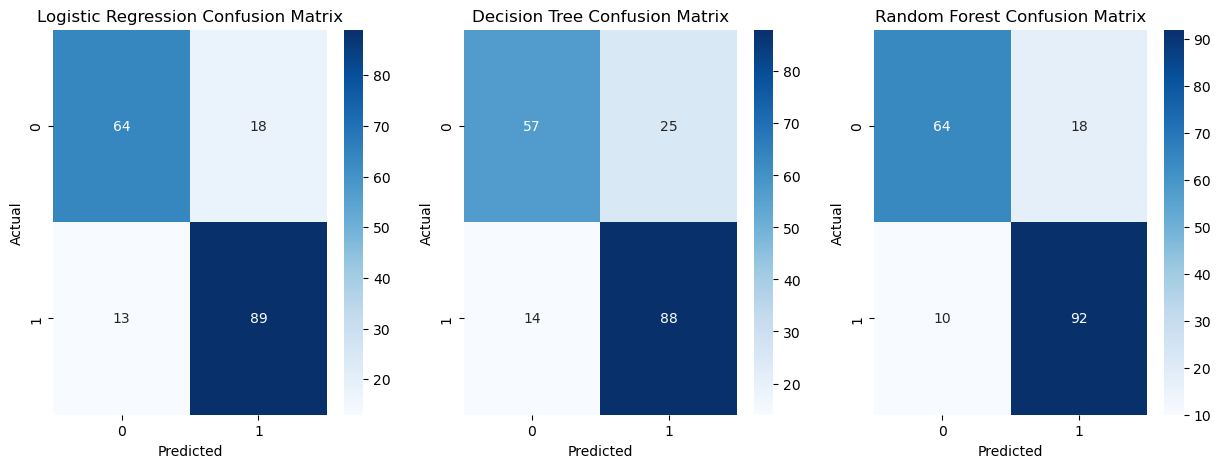

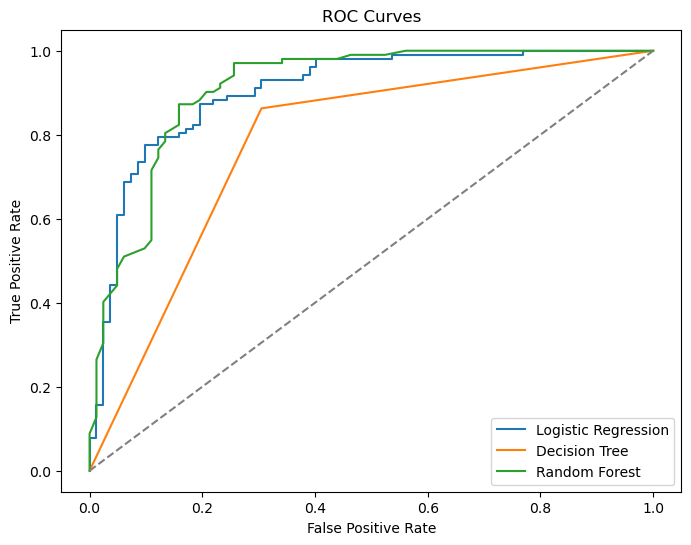

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 1. Load dataset
df = pd.read_csv("heart_disease_uci.csv")

# Create binary target: 0 = no disease, 1 = disease
df['target'] = (df['num'] > 0).astype(int)

# Drop unnecessary columns
df = df.drop(['id', 'dataset', 'num'], axis=1)

# 2. Preprocessing
# Separate categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'bool']).columns
# Separate categorical and numeric columns
cat_cols = df.select_dtypes(include=['object', 'bool']).columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Make sure target is not in num_cols
if 'target' in num_cols:
    num_cols = num_cols.drop('target')


# Handle missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split features & target
X = df.drop('target', axis=1)
y = df['target']

# Scale numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }

# Show results
results_df = pd.DataFrame(results).T
print("\nModel Performance:\n", results_df)

# 4. Visualization
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.show()

# ROC Curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name}")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
